# 尤度関数と確率関数の違いは何なのか？

例：ある県に住む男性の身長の分布を調べたい。身長を平均$\mu$、分散$\sigma^2$の正規分布に従う確率変数$x \sim N(\mu, \sigma^2)$とみなして（仮定して・モデリングして）扱うこととする。

手元にランダム・サンプリングした10人分のデータがあり、次のようになっていたとする。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

n = 10
mu = 170
sigma2 = 25
sigma = np.sqrt(sigma2)

np.random.seed(0)
x = np.random.normal(loc=mu, scale=sigma, size=n).astype(int)
df = pd.DataFrame({"x": x})
df

,x
0,178
1,172
2,174
3,181
4,179
5,165
6,174
7,169
8,169
9,172


## 同時確率関数

10人のデータをとったとして、その組み合わせのデータが得られる確率（同時確率）は、データが独立同分布（i.i.d.）に従うと仮定すると、確率の独立性から同時確率は確率の積

$$
\begin{align}
P(x_1, x_2, \cdots, x_{10}|\mu, \sigma^2)
&= P(x_1|\mu, \sigma^2) P(x_2|\mu, \sigma^2) \cdots P(x_{10}|\mu, \sigma^2)
\\
&= \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma^2}}
\exp \left \{ - \frac{(x_i - \mu)^2}{2\sigma^2} \right \}
\end{align}
$$

と書くことができる。


仮に$\mu = 170, \sigma^2 = 25$とすると、上記の10人の個々の$x$に対応する確率$P(x|\mu, \sigma^2)$は以下の表の`p(x)`列のようになる。


In [2]:
from scipy.stats import norm

df.loc[:, "p(x)"] = norm.pdf(df["x"], loc=mu, scale=sigma)
df

,x,p(x)
0,178,0.022184
1,172,0.073654
2,174,0.057938
3,181,0.007095
4,179,0.015790
5,165,0.048394
6,174,0.057938
7,169,0.078209
8,169,0.078209
9,172,0.073654


In [3]:
from myst_nb import glue
glue("joint_proba", df["p(x)"].product())

1.3396747297828266e-14

これらの積は{glue:}`joint_proba`となる。

パラメータの値を変えつつ確率を計算して分布を描くと次の図のようになる

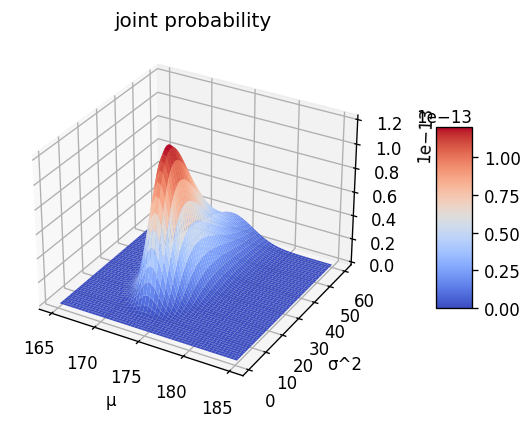

In [14]:
def joint_proba(x, loc: float, scale: float) -> float:
    probabilities = norm.pdf(x, loc=loc, scale=scale)
    return pd.Series(probabilities).product()

# 3d plot
mu_range = np.linspace(165, 185, 50)
sigma2_range = np.linspace(1, 60, 60)

Mu, Sigma2 = np.meshgrid(mu_range, sigma2_range)
Proba = np.array([joint_proba(df["x"], loc=_mu, scale=np.sqrt(_sigma2)) for _mu, _sigma2 in zip(Mu.flatten(), Sigma2.flatten())]).reshape(Mu.shape)

from matplotlib import cm
fig, ax = plt.subplots(dpi=120, subplot_kw={"projection": "3d"})
surf = ax.plot_surface(Mu, Sigma2, Proba, rstride=1, cstride=1, linewidth=1, antialiased=True, cmap=cm.coolwarm)
fig.colorbar(surf, shrink=0.5, aspect=5, pad=0.11)

ax.set(xlabel="μ", ylabel="σ^2", title="joint probability")
fig.show()


$$
P(x|\mu, \sigma^2)
 = \frac{1}{\sqrt{2\pi}\sigma}
 \exp \left\{ - \frac{(x-\mu)^2}{2\sigma^2} \right\}
$$

## 尤度関数

上記のデータが観測される確率が最も高いパラメータ$\mu, \sigma^2$を考えたい。

$$
L(\mu, \sigma^2) = \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma^2}}
\exp \left \{ - \frac{(x_i - \mu)^2}{2\sigma^2} \right \}
$$

### 解析的に解く

計算の簡単のため対数にすると、対数尤度は

$$
\log L(\mu, \sigma^2)
= - \frac{n}{2} \log (2\pi)
- \frac{n}{2} \log \sigma^2
- \frac{1}{2\sigma^2} \sum^n_{i=1} (x_i - \mu)^2
$$

となる。

::::{admonition} 導出メモ
:class: dropdown

まず尤度を軽く整理する

$$
\begin{align}
L(\mu, \sigma^2)
&= \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma^2}}
\exp \left \{ - \frac{(x_i - \mu)^2}{2\sigma^2} \right \}
\\
&= \left( \frac{1}{\sqrt{2\pi\sigma^2}} \right)^n
\prod_{i=1}^n
\exp \left \{ - \frac{(x_i - \mu)^2}{2\sigma^2} \right \}
\end{align}
$$

対数をとると

$$
\begin{align}
\ln L(\mu, \sigma^2)
&= n \ln \left( \frac{1}{\sqrt{2\pi\sigma^2}} \right)
+ \sum^n_{i=1} \ln \left(
\exp \left\{ - \frac{(x_i - \mu)^2}{2\sigma^2} \right\}
\right)
\\
&= n \ln (1) - n \ln (\sqrt{2\pi\sigma^2})
+ \sum^n_{i=1} \left(
- \frac{(x_i - \mu)^2}{2\sigma^2}
\ln e
\right)
\\
&= - n \ln (\sqrt{2\pi\sigma^2})
- \sum^n_{i=1} \frac{(x_i - \mu)^2}{2\sigma^2}
\\
&= - \frac{n}{2} \ln (2\pi)
- \frac{n}{2} \ln \sigma^2
- \frac{1}{2\sigma^2} \sum^n_{i=1} (x_i - \mu)^2
\end{align}
$$


:::{card}
（参考）対数の公式

$$
\begin{align}
\log 1 &= 0\\
\log_e e &= 1\\
\log x^a &= a\log x\\
\log \sqrt{a} &= \log a^{1/2} = \textstyle \frac{1}{2} \log a\\
\log ab &= \log a + \log b\\
\log \frac{a}{b} &= \log a - \log b
\end{align}
$$
:::
::::

これを解くと

$$
\begin{align}
\frac{\partial \log L}{\partial \mu}
&= - \frac{1}{\sigma^2} \sum_{n=1}^n (x_i - \mu) = 0
\\
\frac{\partial \log L}{\partial \sigma^2}
&= - \frac{n}{2\sigma^2}
+ \frac{1}{2\sigma^4} \sum_{n=1}^n (x_i - \mu)^2 = 0
\end{align}
$$

から

$$
\begin{align}
\hat{\mu} &= \bar{x} = \frac{1}{n} \sum^n_{i=1} x_i\\
\hat{\sigma}^2 &=  \frac{1}{n} \sum^n_{i=1} (x_i - \bar{x})^2
\end{align}
$$

となる。

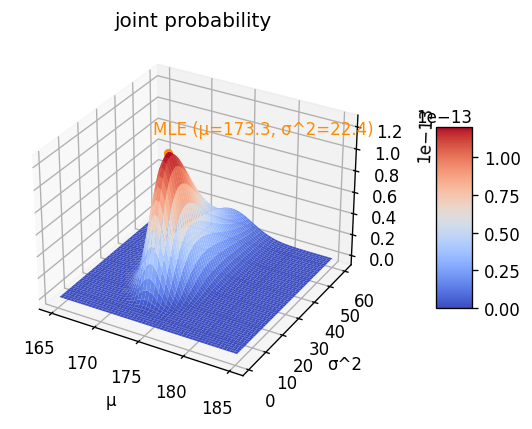

In [37]:
# maximum likelihood estimates
mu_hat = df["x"].sum() / n
sigma2_hat = ((df["x"] - mu_hat)**2).sum() / n
p_hat = joint_proba(df["x"], loc=mu_hat, scale=np.sqrt(sigma2_hat))

# plot
fig, ax = plt.subplots(dpi=120, subplot_kw={"projection": "3d"})
surf = ax.plot_surface(Mu, Sigma2, Proba, rstride=1, cstride=1, linewidth=1, antialiased=True, cmap=cm.coolwarm)
fig.colorbar(surf, shrink=0.5, aspect=5, pad=0.11)

ax.set(xlabel="μ", ylabel="σ^2", title="joint probability")
ax.scatter(mu_hat, sigma2_hat, p_hat, color="darkorange")
ax.text(mu_hat * 0.99, sigma2_hat, p_hat * 1.1, f"MLE (μ={mu_hat:.1f}, σ^2={sigma2_hat:.1f})", color="darkorange")
fig.show()

In [10]:
# from itertools import product
# mu_range = np.linspace(150, 200, 51)
# _sigma = 10

# rows = []
# for _mu in mu_range:
#     probabilities = norm.pdf(df["x"], loc=_mu, scale=_sigma)
#     joint_proba = pd.Series(probabilities).product()
#     row = {"joint_proba": joint_proba, "mu": _mu, "sigma": _sigma}
#     rows.append(row)
# data = pd.DataFrame(rows)

# fig, ax = plt.subplots()
# ax.plot(data["mu"], data["joint_proba"], marker="o")


# from itertools import product


# rows = []
# for _mu, _sigma in product(mu_range, sigma_range):
#     probabilities = norm.pdf(df["x"], loc=_mu, scale=_sigma)
#     joint_proba = pd.Series(probabilities).product()
#     row = {"joint_proba": joint_proba, "mu": _mu, "sigma": _sigma}
#     rows.append(row)
# data = pd.DataFrame(rows)

# fig, ax = plt.subplots()
# ax.scatter(data["mu"], data["joint_proba"])